<a href="https://colab.research.google.com/github/SMN-SENAMHI/S2S/blob/main/APS_week.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Quickstart: NOAA GEFS forecast, 35 day - dynamical.org zarr
Este recurso ofrece una introducción rápida al conjunto de datos del modelo de pronóstico NOAA GEFS (Global Ensemble Forecast System) con horizonte de 35 días, el cual ha sido transformado por Dynamical.org a un formato listo para análisis y optimizado para la nube utilizando Zarr.

*El conjunto de datos incluye variables meteorológicas y climáticas clave, en una estructura que permite:

*Acceso rápido y eficiente desde plataformas en la nube.

*Procesamiento paralelo y en tiempo real para aplicaciones de ciencia de datos, inteligencia artificial o visualización.

*Exploración del pronóstico extendido (S2S: subseasonal to seasonal) con múltiples miembros del ensamble.

🔗 Documentación completa del conjunto de datos:
https://dynamical.org/catalog/noaa-gefs-forecast-35-day/



In [1]:
%pip install "xarray[complete]>=2025.1.2" "zarr>=3.0.4" requests aiohttp > /dev/null 2>&1
!apt-get install -y libproj-dev proj-data proj-bin libgeos-dev > /dev/null 2>&1
!pip install cython > /dev/null 2>&1
!pip install cartopy > /dev/null 2>&1
!pip install geopy > /dev/null 2>&1


In [ ]:
import xarray as xr
import pandas as pd
import warnings
warnings.filterwarnings("ignore")

# ============================
# 1. Abrir dataset GEFS (Zarr)
# ============================
url = "https://data.dynamical.org/noaa/gefs/forecast-35-day/latest.zarr?email=optional@email.com"
ds = xr.open_zarr(url, decode_timedelta=True)

# ============================
# 2. Variables disponibles
# ============================
print("\n📌 Variables disponibles en el dataset GEFS:")
for var in ds.data_vars:
    units = ds[var].attrs.get("units", "")
    desc = ds[var].attrs.get("long_name", "")
    print(f" - {var}: {desc} [{units}]")

# ============================
# 3. Fechas de inicio de pronóstico
# ============================
if "init_time" in ds.coords:
    t0 = pd.to_datetime(ds.init_time.values[0])
    tf = pd.to_datetime(ds.init_time.values[-1])
    print("\n📅 Rango temporal de 'init_time':")
    print("Inicio :", t0.strftime("%Y-%m-%d %H:%M:%S"))
    print("Fin    :", tf.strftime("%Y-%m-%d %H:%M:%S"))

# ============================
# 4. Información de ensembles
# ============================
if "ensemble_member" in ds.dims:
    n_ens = ds.dims["ensemble_member"]
    ens_vals = ds["ensemble_member"].values
    print(f"\n👥 Número de miembros en el ensamble: {n_ens}")
    print("Listado de ensemble_member:")
    print(ens_vals)



📌 Variables disponibles en el dataset GEFS:
 - categorical_freezing_rain_surface: Categorical freezing rain [0=no; 1=yes]
 - categorical_ice_pellets_surface: Categorical ice pellets [0=no; 1=yes]
 - categorical_rain_surface: Categorical rain [0=no; 1=yes]
 - categorical_snow_surface: Categorical snow [0=no; 1=yes]
 - downward_long_wave_radiation_flux_surface: Surface downward long-wave radiation flux [W/(m^2)]
 - downward_short_wave_radiation_flux_surface: Surface downward short-wave radiation flux [W/(m^2)]
 - geopotential_height_cloud_ceiling: Geopotential height [gpm]
 - maximum_temperature_2m: Maximum temperature [C]
 - minimum_temperature_2m: Minimum temperature [C]
 - percent_frozen_precipitation_surface: Percent frozen precipitation [%]
 - precipitable_water_atmosphere: Precipitable water [kg/(m^2)]
 - precipitation_surface: Total Precipitation [mm/s]
 - pressure_reduced_to_mean_sea_level: Pressure reduced to MSL [Pa]
 - pressure_surface: Surface pressure [Pa]
 - relative_humid

📌 Usando init_time: 2025-09-23 00:00:00


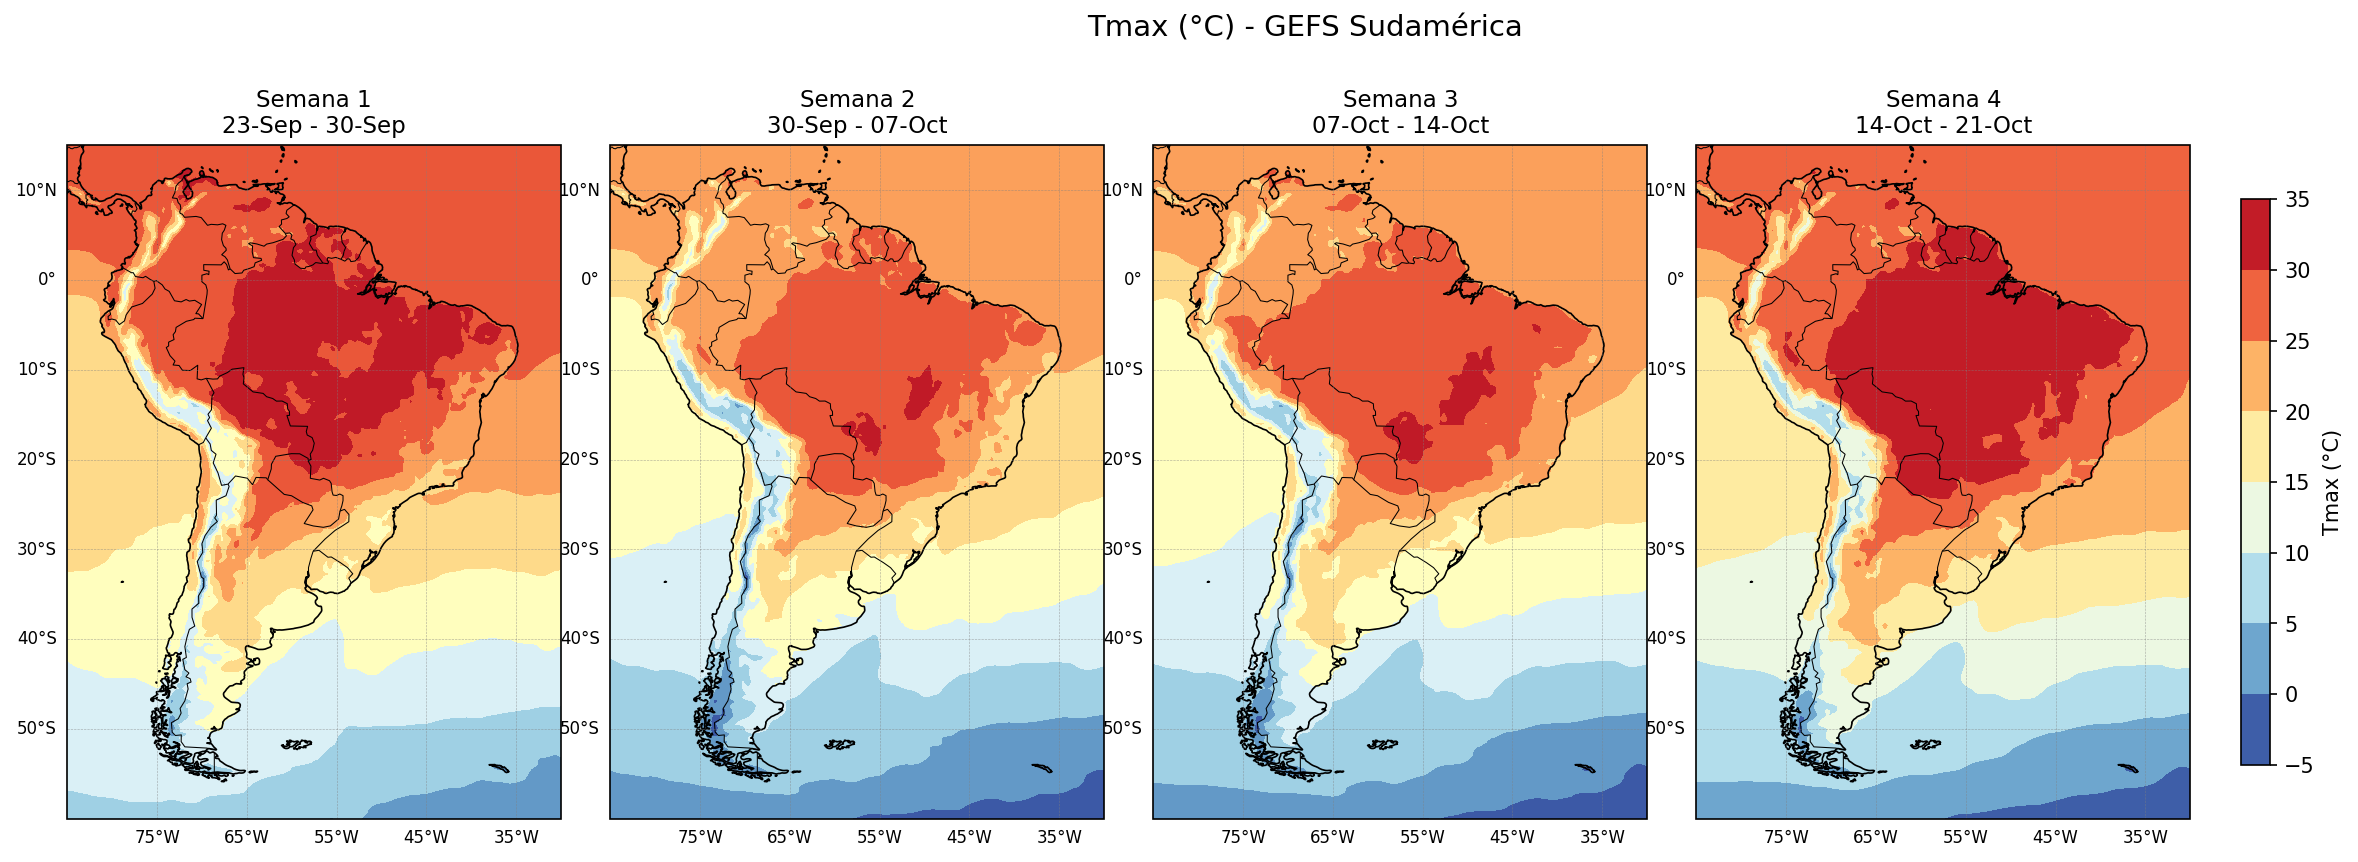

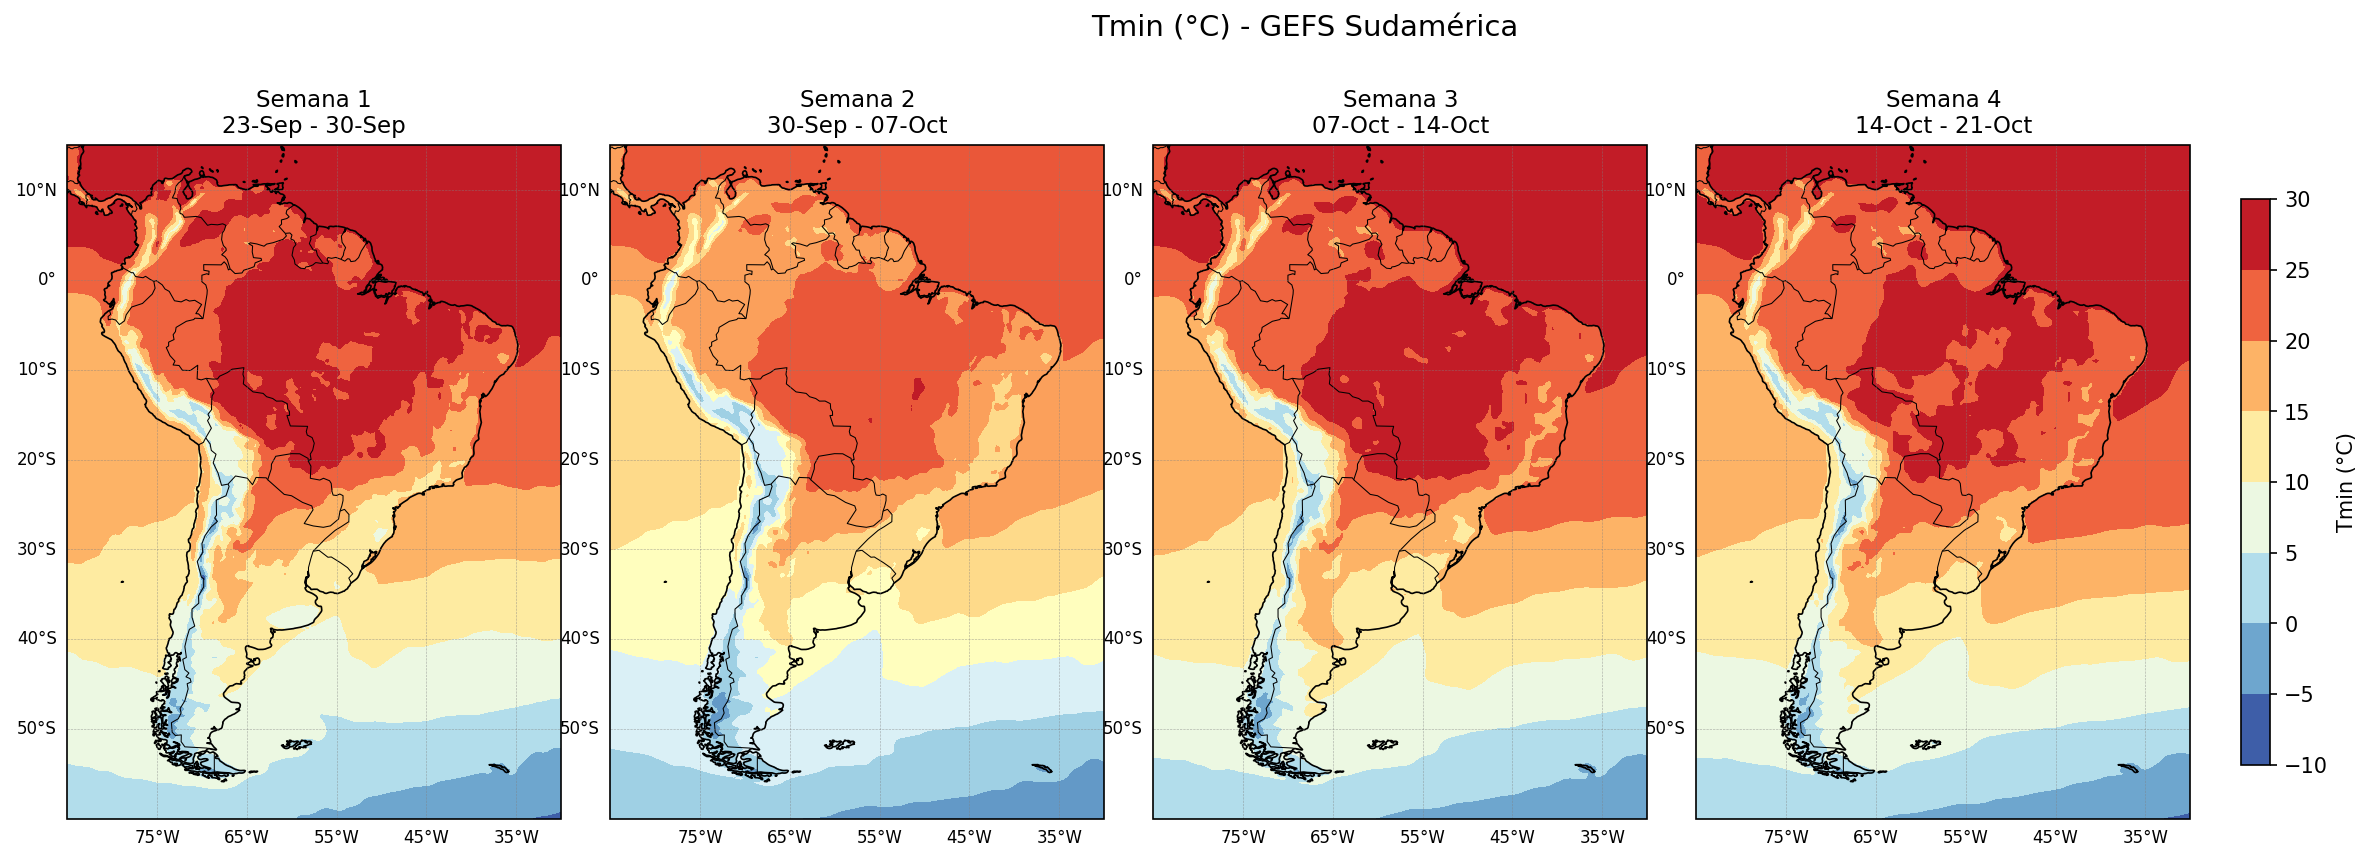

KeyboardInterrupt: 

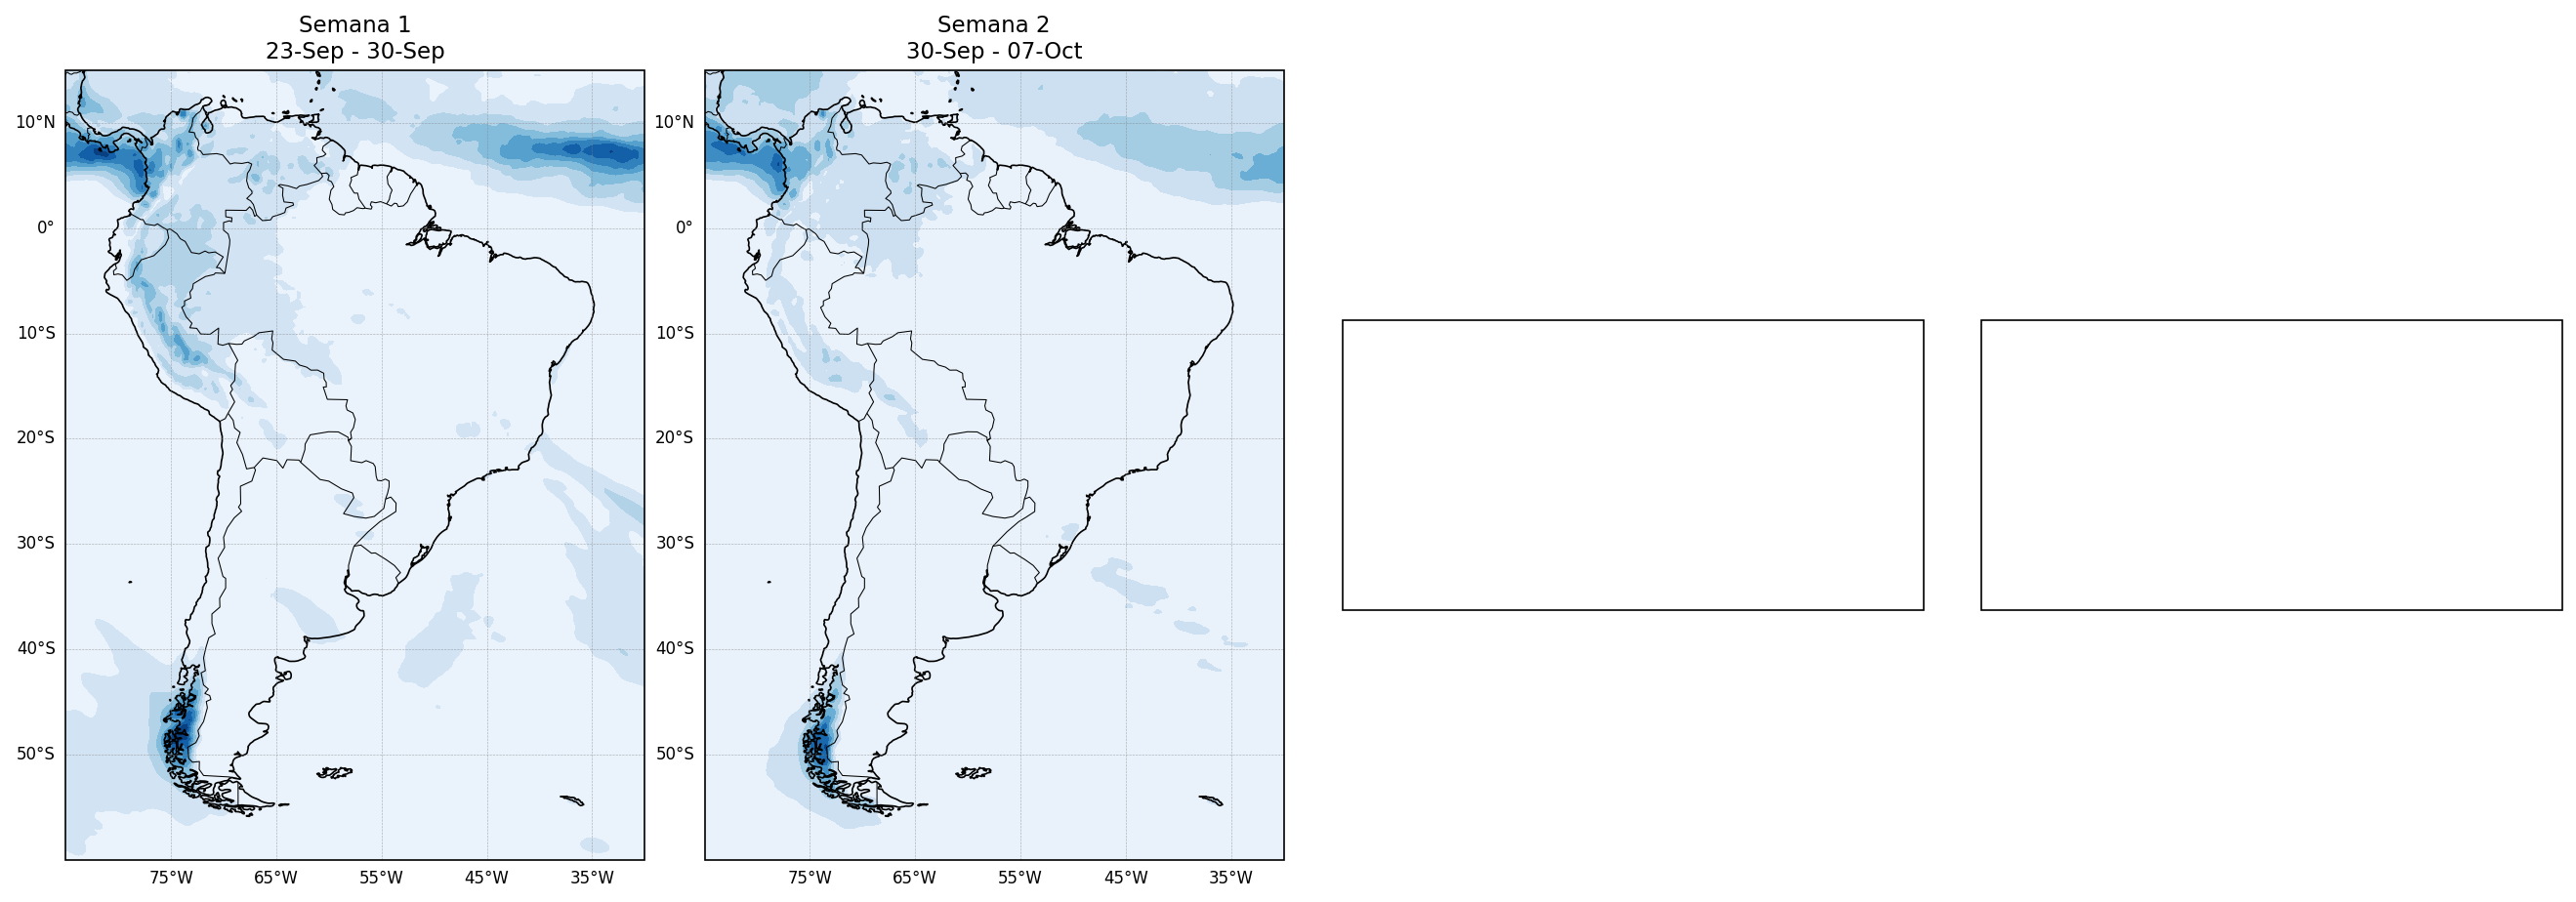

In [ ]:
import xarray as xr
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.ticker as mticker
import warnings
warnings.filterwarnings("ignore")

# ============================
# 1. Abrir dataset GEFS (Zarr)
# ============================
url = "https://data.dynamical.org/noaa/gefs/forecast-35-day/latest.zarr?email=optional@email.com"
ds = xr.open_zarr(url, decode_timedelta=True)

# ============================
# 2. Seleccionar último init_time
# ============================
init_time = ds.init_time.values[-1]
ds_sub = ds.sel(init_time=init_time)
print("📌 Usando init_time:", pd.to_datetime(init_time))

# ============================
# 3. Crear forecast_time real
# ============================
forecast_time = pd.to_datetime(ds_sub.init_time.values) + pd.to_timedelta(ds_sub.lead_time.values)
ds_sub = ds_sub.assign_coords(forecast_time=("lead_time", forecast_time)).swap_dims({"lead_time": "forecast_time"})

# ============================
# 4. Subset para Sudamérica
# ============================
ds_sud = ds_sub.sel(latitude=slice(15, -60), longitude=slice(-85, -30))

# ============================
# 5. Variables de interés
# ============================
tmax = ds_sud["maximum_temperature_2m"]
tmin = ds_sud["minimum_temperature_2m"]
precip = ds_sud["precipitation_surface"] * 86400  # mm/s → mm/día

# ============================
# 6. Agrupar en semanas
# ============================
tmax_weekly = tmax.resample(forecast_time="7D").mean(dim="forecast_time")
tmin_weekly = tmin.resample(forecast_time="7D").mean(dim="forecast_time")
precip_weekly = precip.resample(forecast_time="7D").sum(dim="forecast_time")

# ============================
# 7. Promedio entre miembros
# ============================
tmax_weekly_mean = tmax_weekly.mean(dim="ensemble_member")
tmin_weekly_mean = tmin_weekly.mean(dim="ensemble_member")
precip_weekly_mean = precip_weekly.mean(dim="ensemble_member")

# ============================
# 8. Graficar mapas semanales
# ============================
variables = {
    "Tmax (°C)": tmax_weekly_mean,
    "Tmin (°C)": tmin_weekly_mean,
    "Precipitación (mm/sem)": precip_weekly_mean,
}

extent = [-85, -30, -60, 15]

for name, da in variables.items():
    fig, axes = plt.subplots(1, 4, figsize=(22, 7),
                             subplot_kw={'projection': ccrs.PlateCarree(central_longitude=-60)},
                             dpi=150)
    fig.subplots_adjust(wspace=0.1, hspace=0.3)  # más separación entre filas/columnas

    for i in range(4):
        ax = axes[i]
        field = da.isel(forecast_time=i)
        lon, lat = np.meshgrid(field.longitude, field.latitude)

        # Contorno relleno
        im = ax.contourf(lon, lat, field.values,
                         cmap="RdYlBu_r" if "T" in name else "Blues",
                         transform=ccrs.PlateCarree())

        # Extensión y proyección
        ax.set_extent(extent, crs=ccrs.PlateCarree())
        ax.coastlines(resolution="50m", color="black", linewidth=0.8)
        ax.add_feature(cfeature.BORDERS, linewidth=0.5)
        ax.add_feature(cfeature.LAND, facecolor="lightgray", alpha=0.3)

        # Gridlines (lat/lon)
        gl = ax.gridlines(draw_labels=True, linewidth=0.3, color="gray", alpha=0.6, linestyle="--")
        gl.top_labels = False
        gl.right_labels = False
        gl.xlocator = mticker.FixedLocator(np.arange(-85, -29, 10))
        gl.ylocator = mticker.FixedLocator(np.arange(-60, 16, 10))
        gl.xlabel_style = {"size": 8}
        gl.ylabel_style = {"size": 8}

        # Título de semana
        fecha_ini = pd.to_datetime(str(da.forecast_time.values[i])).strftime("%d-%b")
        fecha_fin = pd.to_datetime(str(da.forecast_time.values[i+1])).strftime("%d-%b") if i+1 < len(da.forecast_time) else ""
        ax.set_title(f"Semana {i+1}\n{fecha_ini} - {fecha_fin}", fontsize=11)

    # Barra de color
    cbar = fig.colorbar(im, ax=axes.ravel().tolist(),
                        orientation="vertical", shrink=0.7, pad=0.02)
    cbar.set_label(name, fontsize=10)

    plt.suptitle(f"{name} - GEFS Sudamérica", fontsize=14, y=0.94)
    plt.show()


In [ ]:
#PRONÓSTICO SEMANAL

In [2]:
#@title Selección de parámetros

# Dropdown de países
Pais_seleccion = "Argentina" #@param ["Brasil", "Colombia", "Venezuela", "Argentina", "Bolivia", "Chile", "Costa Rica", "Ecuador", "French Guiana", "Guyana", "Océano Pacífico", "Panamá", "Paraguay", "Perú", "Suriname", "Uruguay"]

# Calendario para fecha de inicio
Fecha_inicio = "2025-09-23" #@param {type:"date"}

print(f"📌 País seleccionado: {Pais_seleccion}")
print(f"📌 Fecha seleccionada: {Fecha_inicio}")


📌 País seleccionado: Argentina
📌 Fecha seleccionada: 2025-09-23



📌 País seleccionado: Argentina
Bounds: [-73.58537629 -55.05478161 -53.65138475 -21.78396425]
Usando init_time: 2025-09-23 00:00:00


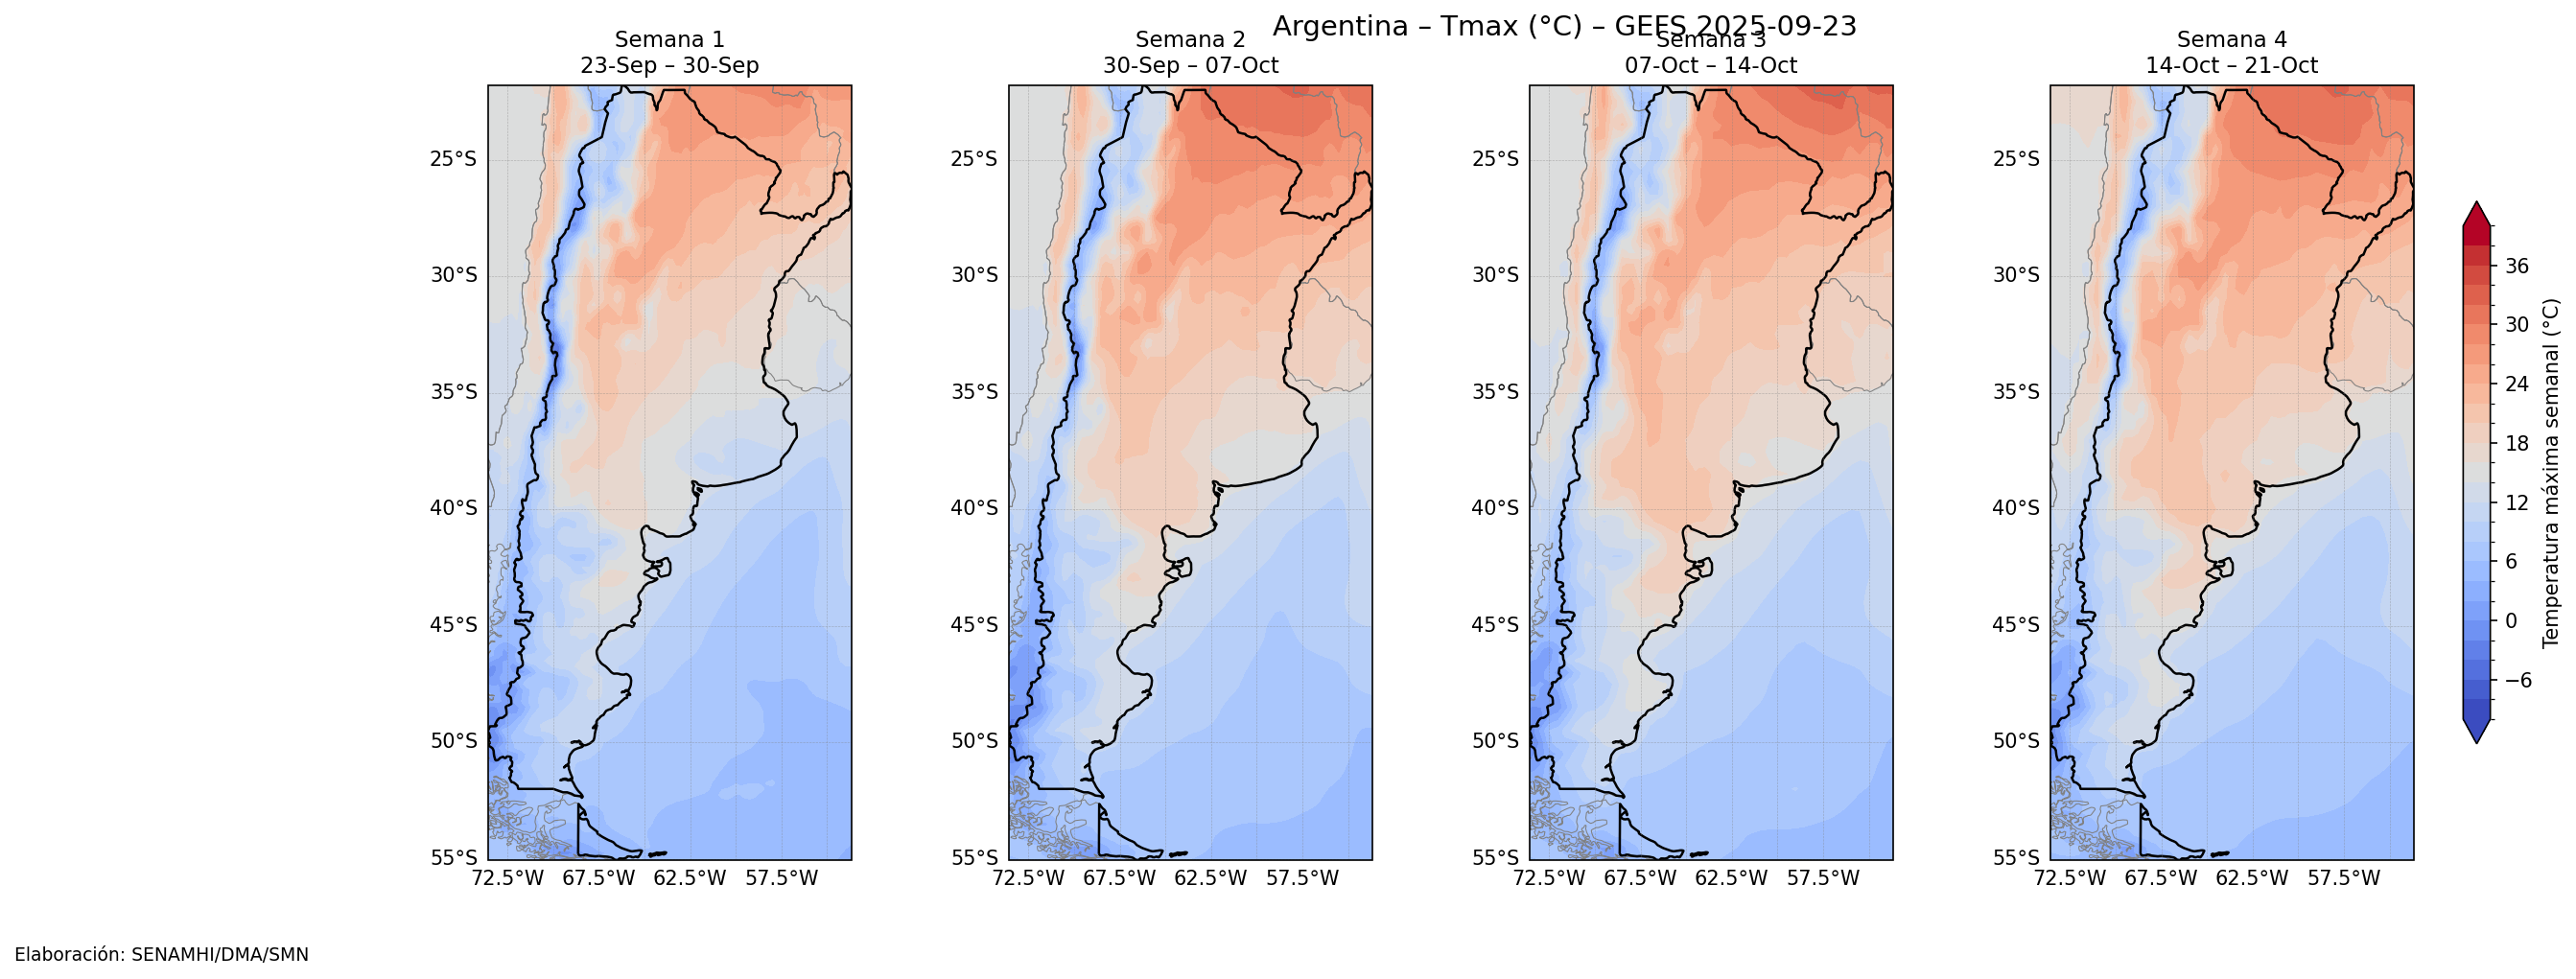

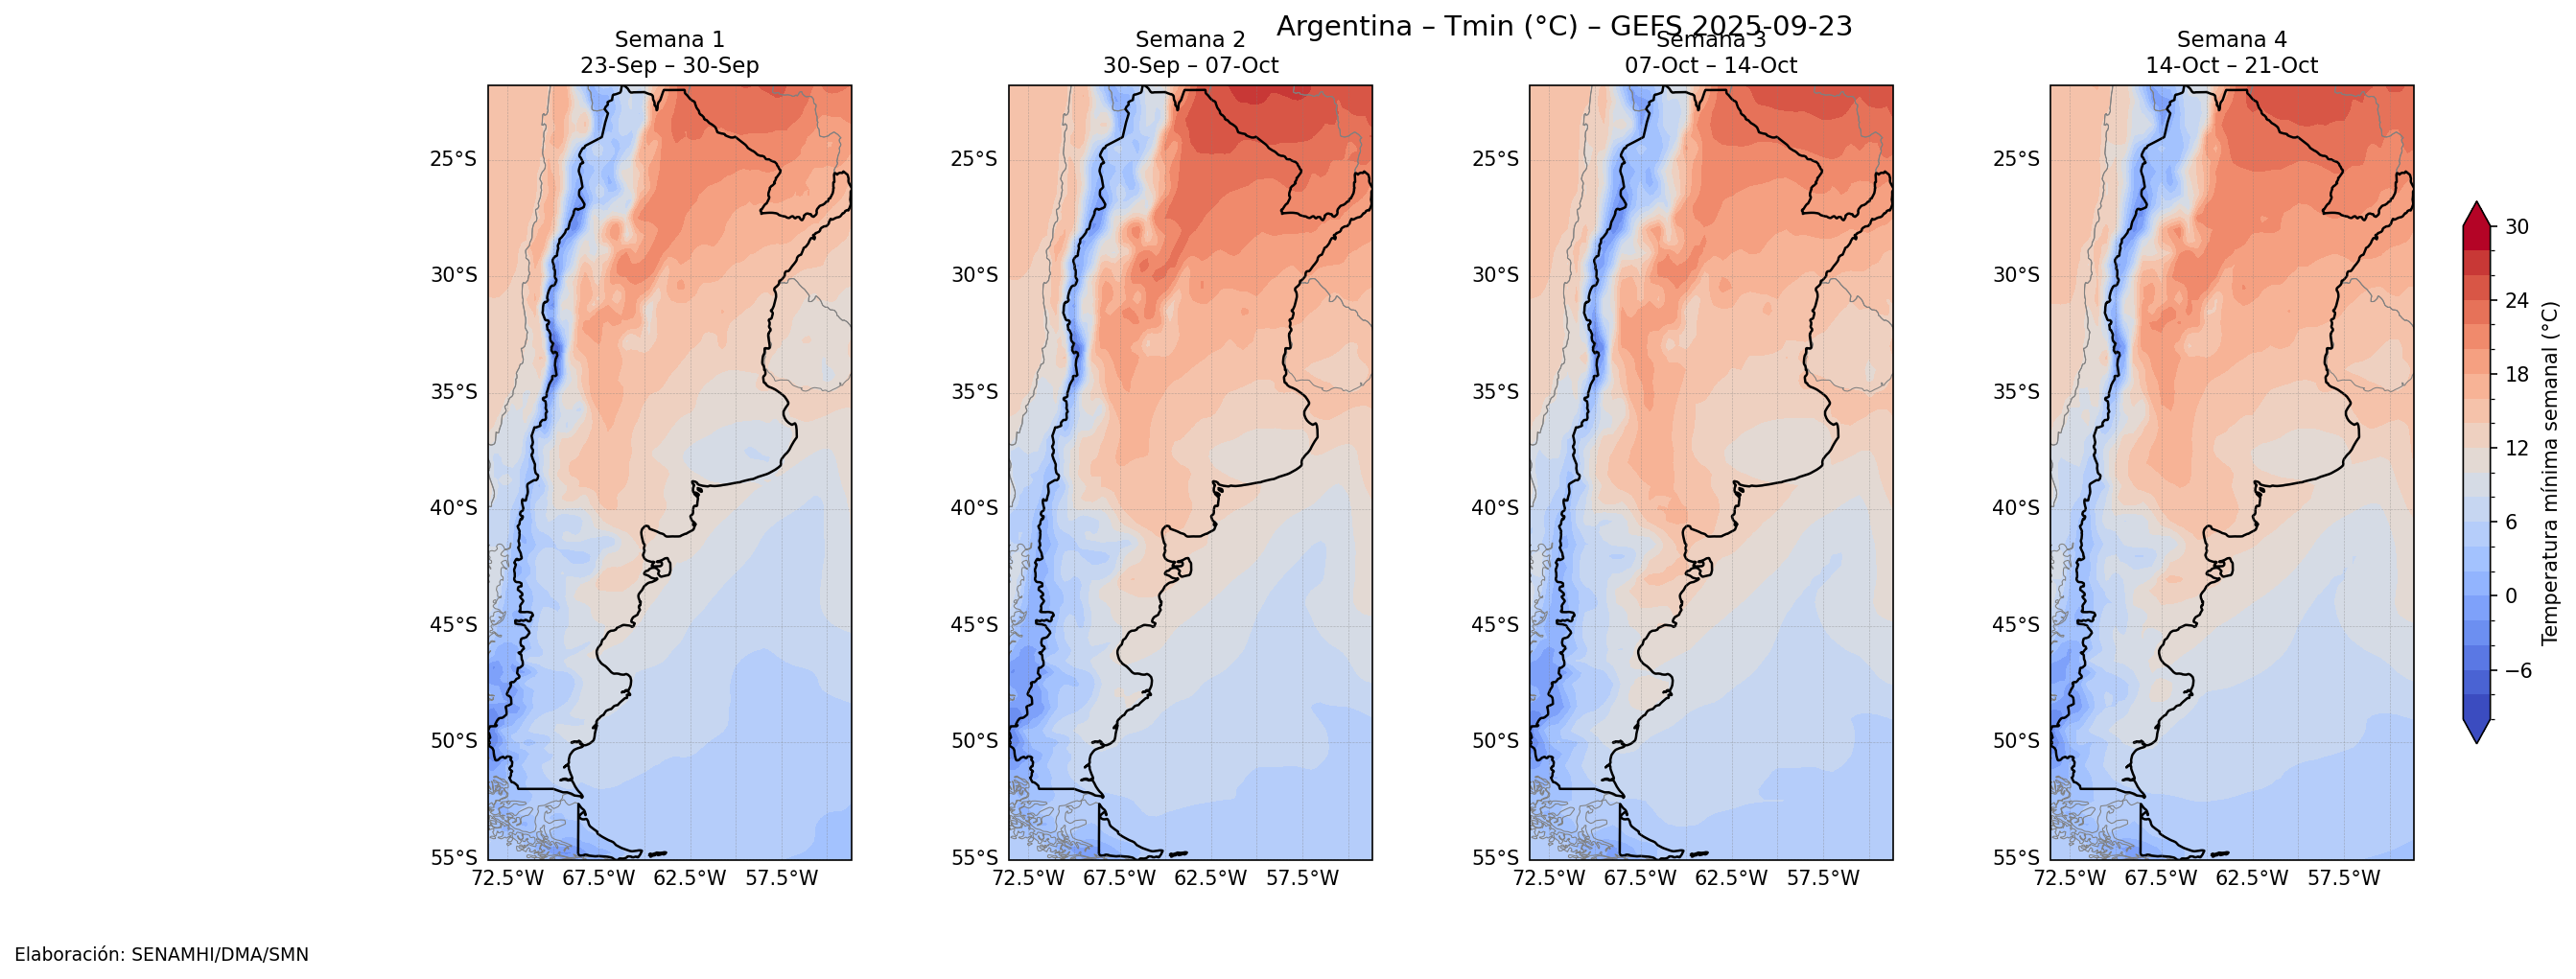

In [ ]:
# ==========================
# LIBRERÍAS
# ==========================
import os
import requests
import xarray as xr
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import numpy as np
from matplotlib.colors import BoundaryNorm
import pandas as pd
import geopandas as gpd
import warnings
warnings.filterwarnings("ignore")

# ==========================
# FUNCIONES AUXILIARES
# ==========================
def download_file(url, local_path):
    r = requests.get(url, stream=True)
    if r.status_code == 200:
        with open(local_path, "wb") as f:
            f.write(r.content)
    else:
        print(f"Error {r.status_code} al descargar {url}")

# ==========================
# SHAPEFILE
# ==========================
shapefiles = {
    "SUDAMERICA.shp": "https://raw.githubusercontent.com/SMN-SENAMHI/Materiales/main/shape/SUDAMERICA.shp",
    "SUDAMERICA.dbf": "https://raw.githubusercontent.com/SMN-SENAMHI/Materiales/main/shape/SUDAMERICA.dbf",
    "SUDAMERICA.shx": "https://raw.githubusercontent.com/SMN-SENAMHI/Materiales/main/shape/SUDAMERICA.shx",
}
for name, url in shapefiles.items():
    download_file(url, name)

# ==========================
# CARGA SHAPEFILE Y PAÍS
# ==========================
gdf = gpd.read_file("SUDAMERICA.shp").set_crs("EPSG:32718").to_crs("EPSG:4326")
gdf["NOMBRE"] = gdf["NOMBRE"].replace({"PerÃº": "Perú", "Panama": "Panamá"})

gdf_pais = gdf[gdf["NOMBRE"].str.upper() == Pais_seleccion.upper()]
if gdf_pais.empty:
    raise ValueError(f"No se encontró el país '{Pais_seleccion}' en el shapefile.")

minx, miny, maxx, maxy = gdf_pais.total_bounds
print(f"\n📌 País seleccionado: {Pais_seleccion}")
print("Bounds:", gdf_pais.total_bounds)

# ==========================
# 3. ABRIR DATASET GEFS (Zarr)
# ==========================
url = "https://data.dynamical.org/noaa/gefs/forecast-35-day/latest.zarr?email=optional@email.com"
ds = xr.open_zarr(url, decode_timedelta=True)

# Selección de init_time (última disponible)
init_time = ds.init_time.values[-1]
ds = ds.sel(init_time=init_time)

# Crear coordenada forecast_time
forecast_time = pd.to_datetime(ds.init_time.values) + pd.to_timedelta(ds.lead_time.values)
ds = ds.assign_coords(forecast_time=("lead_time", forecast_time)).swap_dims({"lead_time": "forecast_time"})
print("Usando init_time:", pd.to_datetime(init_time))

# ==========================
# 4. VARIABLES (semanales, promedio de miembros)
# ==========================
tmax = ds["maximum_temperature_2m"].resample(forecast_time="7D").mean(dim="forecast_time").mean(dim="ensemble_member")
tmin = ds["minimum_temperature_2m"].resample(forecast_time="7D").mean(dim="forecast_time").mean(dim="ensemble_member")
precip = (ds["precipitation_surface"]*86400).resample(forecast_time="7D").sum(dim="forecast_time").mean(dim="ensemble_member")

variables_info = {
    "Tmax (°C)": {
        "data": tmax,
        "cmap": "coolwarm",
        "bounds": np.arange(-10, 41, 2),
        "label": "Temperatura máxima semanal (°C)"
    },
    "Tmin (°C)": {
        "data": tmin,
        "cmap": "coolwarm",
        "bounds": np.arange(-10, 31, 2),
        "label": "Temperatura mínima semanal (°C)"
    },
    "Precipitación (mm/sem)": {
        "data": precip,
        "cmap": "Blues",
        "bounds": [0, 5, 10, 20, 40, 60, 80, 120, 160, 200],
        "label": "Precipitación acumulada (mm/sem)"
    }
}

# ==========================
# 5. LOOP DE VARIABLES → 4 semanas por variable
# ==========================
for name, info in variables_info.items():
    fig, axes = plt.subplots(1, 4, figsize=(22, 7),
                             subplot_kw={'projection': ccrs.PlateCarree()},
                             dpi=150)
    fig.subplots_adjust(wspace=0.1, hspace=0.25)

    for i, ax in enumerate(axes):
        field = info["data"].isel(forecast_time=i)
        lon, lat, values = field.longitude.values, field.latitude.values, field.values.squeeze()

        # Contorno de la variable
        norm = BoundaryNorm(info["bounds"], ncolors=256)
        cs = ax.contourf(lon, lat, values,
                         levels=info["bounds"],
                         cmap=info["cmap"],
                         norm=norm,
                         extend="both",
                         transform=ccrs.PlateCarree())

        # Shapefile del país
        gdf.boundary.plot(ax=ax, color="gray", linewidth=0.5)
        gdf_pais.boundary.plot(ax=ax, color="black", linewidth=1.2)
        ax.set_extent([minx, maxx, miny, maxy], crs=ccrs.PlateCarree())

        # Gridlines
        gl = ax.gridlines(draw_labels=True, linewidth=0.3, color="gray", alpha=0.5, linestyle="--")
        gl.top_labels = False
        gl.right_labels = False

        # Fechas de cada semana
        start_date = pd.to_datetime(str(info["data"].forecast_time[i].values)).strftime("%d-%b")
        if i+1 < len(info["data"].forecast_time):
            end_date = pd.to_datetime(str(info["data"].forecast_time[i+1].values)).strftime("%d-%b")
        else:
            end_date = ""
        ax.set_title(f"Semana {i+1}\n{start_date} – {end_date}", fontsize=11)

    # Barra de color común
    cbar = fig.colorbar(cs, ax=axes.ravel().tolist(),
                        orientation="vertical", shrink=0.7, pad=0.02)
    cbar.set_label(info["label"])

    # Título general
    plt.suptitle(f"{Pais_seleccion} – {name} – GEFS {pd.to_datetime(init_time).strftime('%Y-%m-%d')}",
                 fontsize=14, y=0.95)

    # Créditos
    plt.figtext(0.01, 0.01, "Elaboración: SENAMHI/DMA/SMN",
                ha="left", fontsize=9, color="black",
                bbox=dict(facecolor="white", alpha=0.6, edgecolor="none"))

    plt.show()

print("✅ Proceso completado.")



 País seleccionado: Argentina
Bounds: [-73.58537629 -55.05478161 -53.65138475 -21.78396425]
Usando init_time: 2025-09-23 00:00:00


Procesando Tmax (°C):   0%|          | 0/4 [00:00<?, ?it/s]

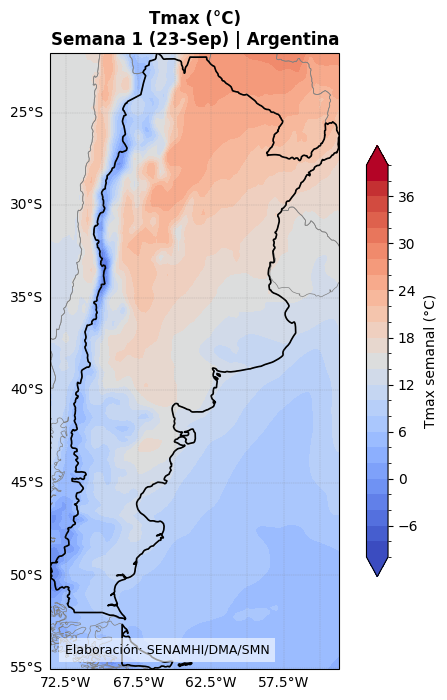

Procesando Tmax (°C):  25%|██▌       | 1/4 [10:26<31:18, 626.01s/it]


KeyboardInterrupt: 

In [9]:
# ==========================
# LIBRERÍAS
# ==========================
import os
import requests
import xarray as xr
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import numpy as np
from matplotlib.colors import BoundaryNorm
import pandas as pd
import geopandas as gpd
from tqdm import tqdm
import warnings
warnings.filterwarnings("ignore")

# ==========================
# FUNCIONES AUXILIARES
# ==========================
def download_file(url, local_path):
    r = requests.get(url, stream=True)
    if r.status_code == 200:
        with open(local_path, "wb") as f:
            f.write(r.content)
    else:
        print(f"Error {r.status_code} al descargar {url}")

# ==========================
# SHAPEFILE
# ==========================
shapefiles = {
    "SUDAMERICA.shp": "https://raw.githubusercontent.com/SMN-SENAMHI/Materiales/main/shape/SUDAMERICA.shp",
    "SUDAMERICA.dbf": "https://raw.githubusercontent.com/SMN-SENAMHI/Materiales/main/shape/SUDAMERICA.dbf",
    "SUDAMERICA.shx": "https://raw.githubusercontent.com/SMN-SENAMHI/Materiales/main/shape/SUDAMERICA.shx",
}
for name, url in shapefiles.items():
    download_file(url, name)

# ==========================
# CARGA SHAPEFILE Y PAÍS
# ==========================
gdf = gpd.read_file("SUDAMERICA.shp").set_crs("EPSG:32718").to_crs("EPSG:4326")
gdf["NOMBRE"] = gdf["NOMBRE"].replace({"PerÃº": "Perú", "Panama": "Panamá"})

gdf_pais = gdf[gdf["NOMBRE"].str.upper() == Pais_seleccion.upper()]
if gdf_pais.empty:
    raise ValueError(f"No se encontró el país '{Pais_seleccion}' en el shapefile.")

minx, miny, maxx, maxy = gdf_pais.total_bounds

print(f"\n País seleccionado: {Pais_seleccion}")
print("Bounds:", gdf_pais.total_bounds)

# ==========================
# 3. ABRIR DATASET GEFS (Zarr)
# ==========================
url = "https://data.dynamical.org/noaa/gefs/forecast-35-day/latest.zarr?email=optional@email.com"
ds = xr.open_zarr(url, decode_timedelta=True)

# Selección de init_time (última disponible)
init_time = ds.init_time.values[-1]
ds = ds.sel(init_time=init_time)

# Crear coordenada forecast_time
forecast_time = pd.to_datetime(ds.init_time.values) + pd.to_timedelta(ds.lead_time.values)
ds = ds.assign_coords(forecast_time=("lead_time", forecast_time)).swap_dims({"lead_time": "forecast_time"})

print("Usando init_time:", pd.to_datetime(init_time))

# ==========================
# 4. VARIABLES (semanales, promedio de miembros)
# ==========================
tmax = ds["maximum_temperature_2m"].resample(forecast_time="7D").mean(dim="forecast_time").mean(dim="ensemble_member")
tmin = ds["minimum_temperature_2m"].resample(forecast_time="7D").mean(dim="forecast_time").mean(dim="ensemble_member")
precip = (ds["precipitation_surface"]*86400).resample(forecast_time="7D").sum(dim="forecast_time").mean(dim="ensemble_member")

variables_info = {
    "Tmax (°C)": {
        "data": tmax,
        "cmap": "coolwarm",
        "bounds": np.arange(-10, 41, 2),
        "label": "Tmax semanal (°C)"
    },
    "Tmin (°C)": {
        "data": tmin,
        "cmap": "coolwarm",
        "bounds": np.arange(-10, 31, 2),
        "label": "Tmin semanal (°C)"
    },
    "Precipitación (mm/sem)": {
        "data": precip,
        "cmap": "Blues",
        "bounds": [0, 5, 10, 20, 40, 60, 80, 120, 160, 200],
        "label": "Precipitación acumulada (mm/sem)"
    }
}

# ==========================
# FUNCIÓN DE PLOT
# ==========================
def plot_variable(name, info, week_idx, gdf, gdf_pais, pais_nombre):
    field = info["data"].isel(forecast_time=week_idx)
    lon, lat, values = field.longitude.values, field.latitude.values, field.values.squeeze()

    fig, ax = plt.subplots(figsize=(7, 8), subplot_kw={"projection": ccrs.PlateCarree()})
    norm = BoundaryNorm(info["bounds"], ncolors=256)
    cs = ax.contourf(lon, lat, values, levels=info["bounds"], cmap=info["cmap"], norm=norm, extend="both")

    # Shapefile
    gdf.boundary.plot(ax=ax, color="gray", linewidth=0.5)
    gdf_pais.boundary.plot(ax=ax, color="black", linewidth=1.2)
    ax.set_extent([minx, maxx, miny, maxy], crs=ccrs.PlateCarree())

    # Gridlines
    gl = ax.gridlines(draw_labels=True, linewidth=0.3, color="gray", alpha=0.5, linestyle="--")
    gl.top_labels = False
    gl.right_labels = False

    # Fechas de la semana
    fechas = field.forecast_time.values
    fecha_ini = pd.to_datetime(str(fechas)).strftime("%d-%b")

    ax.set_title(f"{name}\nSemana {week_idx+1} ({fecha_ini}) | {pais_nombre}",
                 fontsize=12, fontweight="bold")

    cbar = fig.colorbar(cs, ax=ax, orientation="vertical", shrink=0.7)
    cbar.set_label(info["label"])

    ax.text(0.05, 0.02, 'Elaboración: SENAMHI/DMA/SMN',
            horizontalalignment='left', verticalalignment='bottom',
            transform=ax.transAxes, fontsize=9, color='black',
            bbox=dict(facecolor='white', alpha=0.6, edgecolor='none'))
    plt.show()

# ==========================
# LOOP DE PLOTS
# ==========================
for name, info in variables_info.items():
    for i in tqdm(range(4), desc=f"Procesando {name}"):
        plot_variable(name, info, i, gdf, gdf_pais, Pais_seleccion)

print("✅ Proceso completado.")


Usando init_time: 2025-06-30


/usr/local/lib/python3.11/dist-packages/cartopy/io/__init__.py:241: DownloadWarning: Downloading: https://naturalearth.s3.amazonaws.com/110m_physical/ne_110m_land.zip
  warnings.warn(f'Downloading: {url}', DownloadWarning)
/usr/local/lib/python3.11/dist-packages/cartopy/io/__init__.py:241: DownloadWarning: Downloading: https://naturalearth.s3.amazonaws.com/110m_physical/ne_110m_coastline.zip
  warnings.warn(f'Downloading: {url}', DownloadWarning)
/usr/local/lib/python3.11/dist-packages/cartopy/io/__init__.py:241: DownloadWarning: Downloading: https://naturalearth.s3.amazonaws.com/110m_cultural/ne_110m_admin_0_boundary_lines_land.zip
  warnings.warn(f'Downloading: {url}', DownloadWarning)


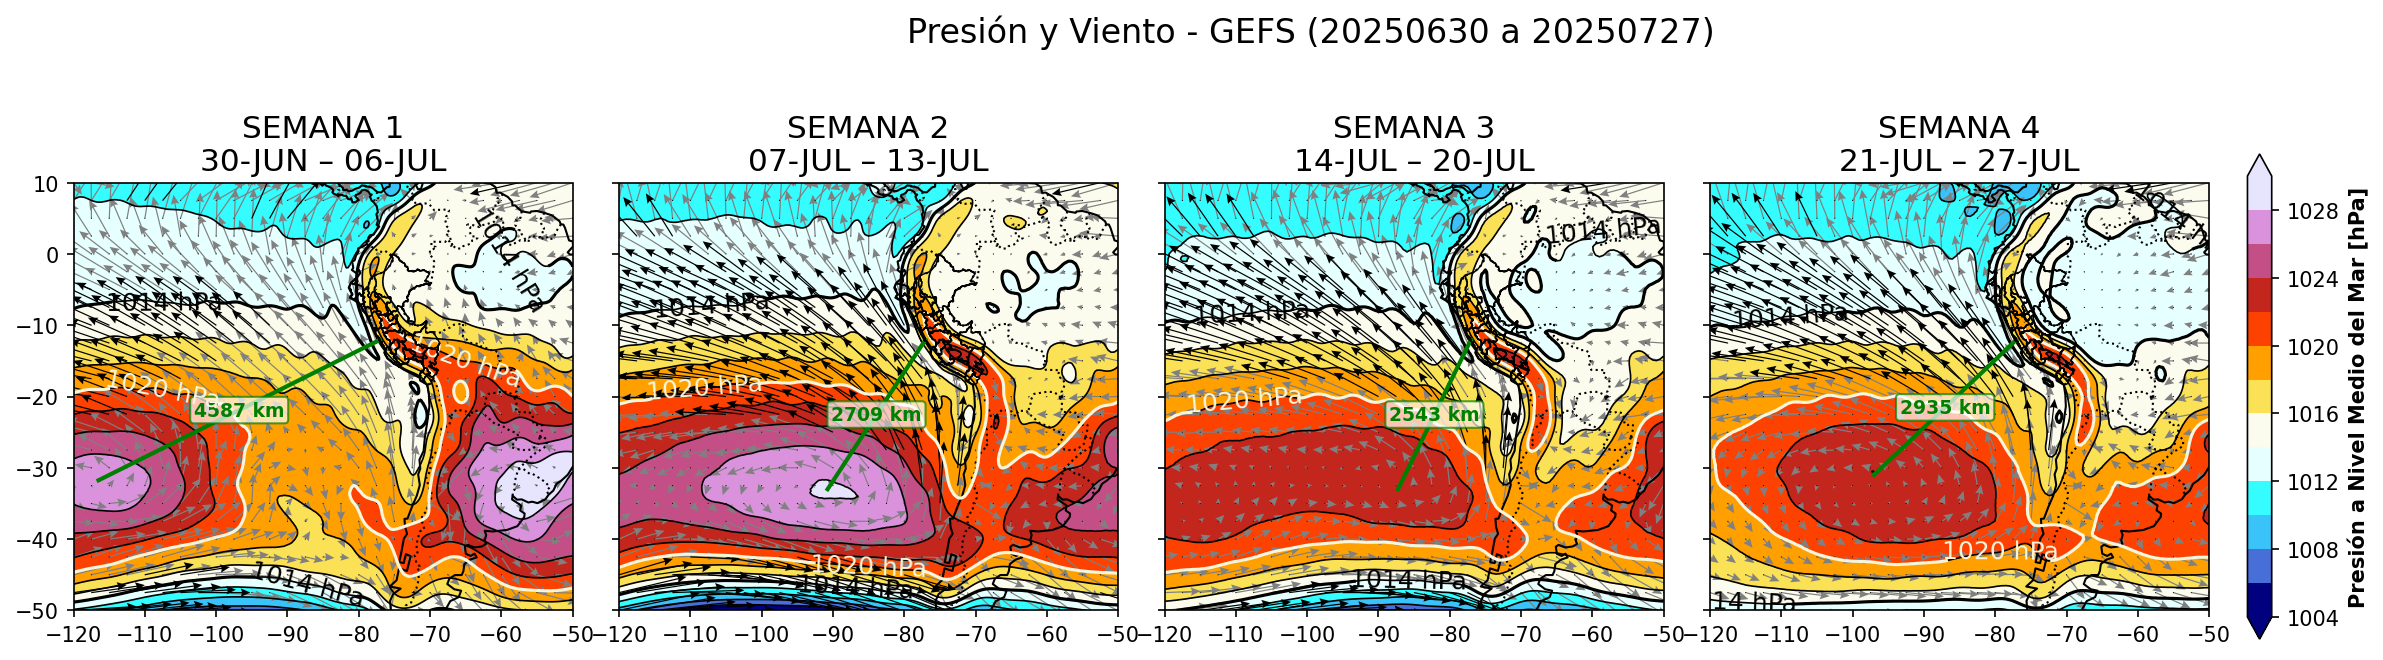

Imagen guardada como: ASP_presion_viento_20250630_20250727_init20250630.png


In [ ]:
import xarray as xr
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import geopandas as gpd
import numpy as np
import pandas as pd
import tempfile
import requests
import os
from geopy.distance import geodesic
import warnings
warnings.filterwarnings("ignore")

# FECHA DE INICIO MANUAL
fecha_inicio_manual = "2025-06-30"  # Cambiar aquí la fecha deseada o usar None

# === 1. Descargar shapefile de Perú
shapefiles = {
    "departamentos.shp": "https://raw.githubusercontent.com/SMN-SENAMHI/Materiales/main/shape/DEPARTAMENTOS.shp",
    "departamentos.dbf": "https://raw.githubusercontent.com/SMN-SENAMHI/Materiales/main/shape/DEPARTAMENTOS.dbf",
    "departamentos.shx": "https://raw.githubusercontent.com/SMN-SENAMHI/Materiales/main/shape/DEPARTAMENTOS.shx",
}

tempdir = tempfile.mkdtemp()
for filename, url in shapefiles.items():
    response = requests.get(url)
    with open(os.path.join(tempdir, filename), "wb") as f:
        f.write(response.content)

gdf_peru = gpd.read_file(os.path.join(tempdir, "departamentos.shp"))

# === 2. Abrir dataset GEFS
ds = xr.open_zarr(
    "https://data.dynamical.org/noaa/gefs/forecast-35-day/latest.zarr?email=optional@email.com",
    decode_timedelta=True
)

# Selección de fecha de inicio
init_times = pd.to_datetime(ds.init_time.values)
if fecha_inicio_manual:
    fecha_inicio_manual_dt = np.datetime64(fecha_inicio_manual)
    if fecha_inicio_manual_dt in ds.init_time.values:
        init_time_usado = fecha_inicio_manual_dt
    else:
        raise ValueError(f"La fecha '{fecha_inicio_manual}' no está disponible en los datos.")
else:
    init_time_usado = init_times.max()

print("Usando init_time:", pd.to_datetime(init_time_usado).strftime("%Y-%m-%d"))

# === 3. Subset de región
ds_sub = ds.sel(init_time=init_time_usado).sel(latitude=slice(10, -50), longitude=slice(-120, -50))
ds_members = ds_sub.sel(lead_time=slice("0h", "27d"))

pressure_all = ds_members["pressure_reduced_to_mean_sea_level"] / 100  # Pa a hPa
u10_all = ds_members["wind_u_10m"]
v10_all = ds_members["wind_v_10m"]

# === 4. Ajuste de tiempo
forecast_time = ds_members.init_time + ds_members.lead_time
pressure_all = pressure_all.assign_coords(forecast_time=forecast_time).swap_dims({"lead_time": "forecast_time"})
u10_all = u10_all.assign_coords(forecast_time=forecast_time).swap_dims({"lead_time": "forecast_time"})
v10_all = v10_all.assign_coords(forecast_time=forecast_time).swap_dims({"lead_time": "forecast_time"})

# === 5. Agrupar por día
pressure_daily_all = pressure_all.groupby("forecast_time.date").mean(dim="forecast_time")
u10_daily_all = u10_all.groupby("forecast_time.date").mean(dim="forecast_time")
v10_daily_all = v10_all.groupby("forecast_time.date").mean(dim="forecast_time")

# === 6. Semanas
semanas = {
    "SEMANA 1": slice(0, 7),
    "SEMANA 2": slice(7, 14),
    "SEMANA 3": slice(14, 21),
    "SEMANA 4": slice(21, 28),
}

# === 7. Promedio de ensamble
pressure_prom = pressure_daily_all.mean(dim="ensemble_member")
u10_prom = u10_daily_all.mean(dim="ensemble_member")
v10_prom = v10_daily_all.mean(dim="ensemble_member")

# === 8. Configuración visual
extent = [-120, -50, -50, 10]
x_ticks = range(-120, -49, 10)
y_ticks = range(-50, 11, 10)

colors = ["#01007E", "#486ED7", "#39C3F8", "#35FCFF", "#E6FFFF",
          "#FBFCEE", "#F6F6DE", "#FAE156", "#FFA000", "#FC4100",
          "#C3261D", "#C34F86", "#DA92DD", "#E7E5FD"]
cmap_custom = mcolors.ListedColormap(colors)
contour_levels = np.arange(1004, 1032, 2)

# === 9. Graficar
fig, axes = plt.subplots(1, 4, figsize=(22, 6), subplot_kw={'projection': ccrs.PlateCarree()}, dpi=150)
fig.subplots_adjust(wspace=0.093, hspace=0)

for i, (ax, (semana, rango)) in enumerate(zip(axes, semanas.items())):
    pres_avg = pressure_prom.isel(date=rango).mean(dim="date")
    u10_avg = u10_prom.isel(date=rango).mean(dim="date")
    v10_avg = v10_prom.isel(date=rango).mean(dim="date")

    lon, lat = np.meshgrid(pres_avg.longitude.values, pres_avg.latitude.values)
    uwnd_values = u10_avg.values
    vwnd_values = v10_avg.values
    mslp_values = pres_avg.values

    wind_magnitude = np.sqrt(uwnd_values**2 + vwnd_values**2)
    mask_black = wind_magnitude > 7
    mask_gray = ~mask_black

    ax.set_extent(extent, crs=ccrs.PlateCarree())
    ax.set_xticks(x_ticks, crs=ccrs.PlateCarree())
    ax.set_yticks(y_ticks, crs=ccrs.PlateCarree())
    ax.tick_params(labelbottom=True, labelleft=(i == 0))
    ax.coastlines()
    ax.add_feature(cfeature.BORDERS, linestyle=":")
    ax.add_feature(cfeature.LAND, edgecolor='black', alpha=0.3)

    cmap_mslp = ax.contourf(lon, lat, mslp_values, levels=contour_levels, cmap=cmap_custom, extend='both')
    ax.contour(lon, lat, mslp_values, levels=contour_levels, colors='black', linewidths=0.8)

    ax.clabel(ax.contour(lon, lat, mslp_values, levels=[1020], colors='#F6F6DC', linewidths=1.5),
              inline=True, fontsize=12, fmt='%d hPa', colors='#F6F6DC')
    ax.clabel(ax.contour(lon, lat, mslp_values, levels=[1014], colors='black', linewidths=1.5),
              inline=True, fontsize=12, fmt='%d hPa', colors='black')

    skip = (slice(None, None, 10), slice(None, None, 10))
    ax.quiver(lon[skip], lat[skip],
              uwnd_values[skip] * mask_gray[skip], vwnd_values[skip] * mask_gray[skip],
              color='#808080', scale=1.0, scale_units='xy', headlength=8, headwidth=7, headaxislength=7)
    ax.quiver(lon[skip], lat[skip],
              uwnd_values[skip] * mask_black[skip], vwnd_values[skip] * mask_black[skip],
              color='black', scale=1.0, scale_units='xy', headlength=8, headwidth=7, headaxislength=7)

    gdf_peru.boundary.plot(ax=ax, edgecolor='black', linewidth=0.7, zorder=10)

    # Cálculo del punto de máxima presión SOLO en el área especificada
    pres_sub = pres_avg.sel(latitude=slice(-10, -50), longitude=slice(-120, -77))
    lon_sub, lat_sub = np.meshgrid(pres_sub.longitude.values, pres_sub.latitude.values)
    idx_max = np.unravel_index(np.argmax(pres_sub.values, axis=None), pres_sub.shape)
    lat_max = lat_sub[idx_max]
    lon_max = lon_sub[idx_max]
    lat_lima, lon_lima = -12.05, -77.04

    ax.plot([lon_max, lon_lima], [lat_max, lat_lima], color='green', linewidth=2, transform=ccrs.PlateCarree())
    distancia_km = geodesic((lat_max, lon_max), (lat_lima, lon_lima)).kilometers
    lat_text = (lat_max + lat_lima) / 2
    lon_text = (lon_max + lon_lima) / 2
    ax.text(lon_text, lat_text, f"{distancia_km:.0f} km", fontsize=9, color='green',
            weight='bold', transform=ccrs.PlateCarree(), ha='center', va='center',
            bbox=dict(boxstyle="round,pad=0.2", fc="white", ec="green", alpha=0.7))

    week_dates = pressure_prom.date.values[rango]
    start_date = pd.to_datetime(str(week_dates[0])).strftime("%d-%b").upper()
    end_date = pd.to_datetime(str(week_dates[-1])).strftime("%d-%b").upper()
    ax.set_title(f"{semana}\n{start_date} – {end_date}", fontsize=15)

# === 10. Barra de color
cbar = fig.colorbar(cmap_mslp, ax=axes.ravel().tolist(), orientation="vertical", shrink=0.7, pad=0.015)
cbar.set_label("Presión a Nivel Medio del Mar [hPa]", fontsize=10, weight='bold')

# === 11. Guardar
start_forecast = pd.to_datetime(str(pressure_prom.date.values[0])).strftime("%Y%m%d")
end_forecast = pd.to_datetime(str(pressure_prom.date.values[-1])).strftime("%Y%m%d")
output_file = f"ASP_presion_viento_{start_forecast}_{end_forecast}_init{pd.to_datetime(init_time_usado).strftime('%Y%m%d')}.png"
plt.suptitle(f"Presión y Viento - GEFS ({start_forecast} a {end_forecast})", fontsize=16, y=0.92)
plt.savefig(output_file, bbox_inches='tight', pad_inches=0.1)
plt.show()

print(f"Imagen guardada como: {output_file}")


In [ ]:
#PRONÓNSTICO DIARIO (6 DÍAS)

Usando init_time: 2025-06-30


/usr/local/lib/python3.11/dist-packages/cartopy/io/__init__.py:241: DownloadWarning: Downloading: https://naturalearth.s3.amazonaws.com/110m_physical/ne_110m_land.zip
  warnings.warn(f'Downloading: {url}', DownloadWarning)
/usr/local/lib/python3.11/dist-packages/cartopy/io/__init__.py:241: DownloadWarning: Downloading: https://naturalearth.s3.amazonaws.com/110m_physical/ne_110m_coastline.zip
  warnings.warn(f'Downloading: {url}', DownloadWarning)
/usr/local/lib/python3.11/dist-packages/cartopy/io/__init__.py:241: DownloadWarning: Downloading: https://naturalearth.s3.amazonaws.com/110m_cultural/ne_110m_admin_0_boundary_lines_land.zip
  warnings.warn(f'Downloading: {url}', DownloadWarning)


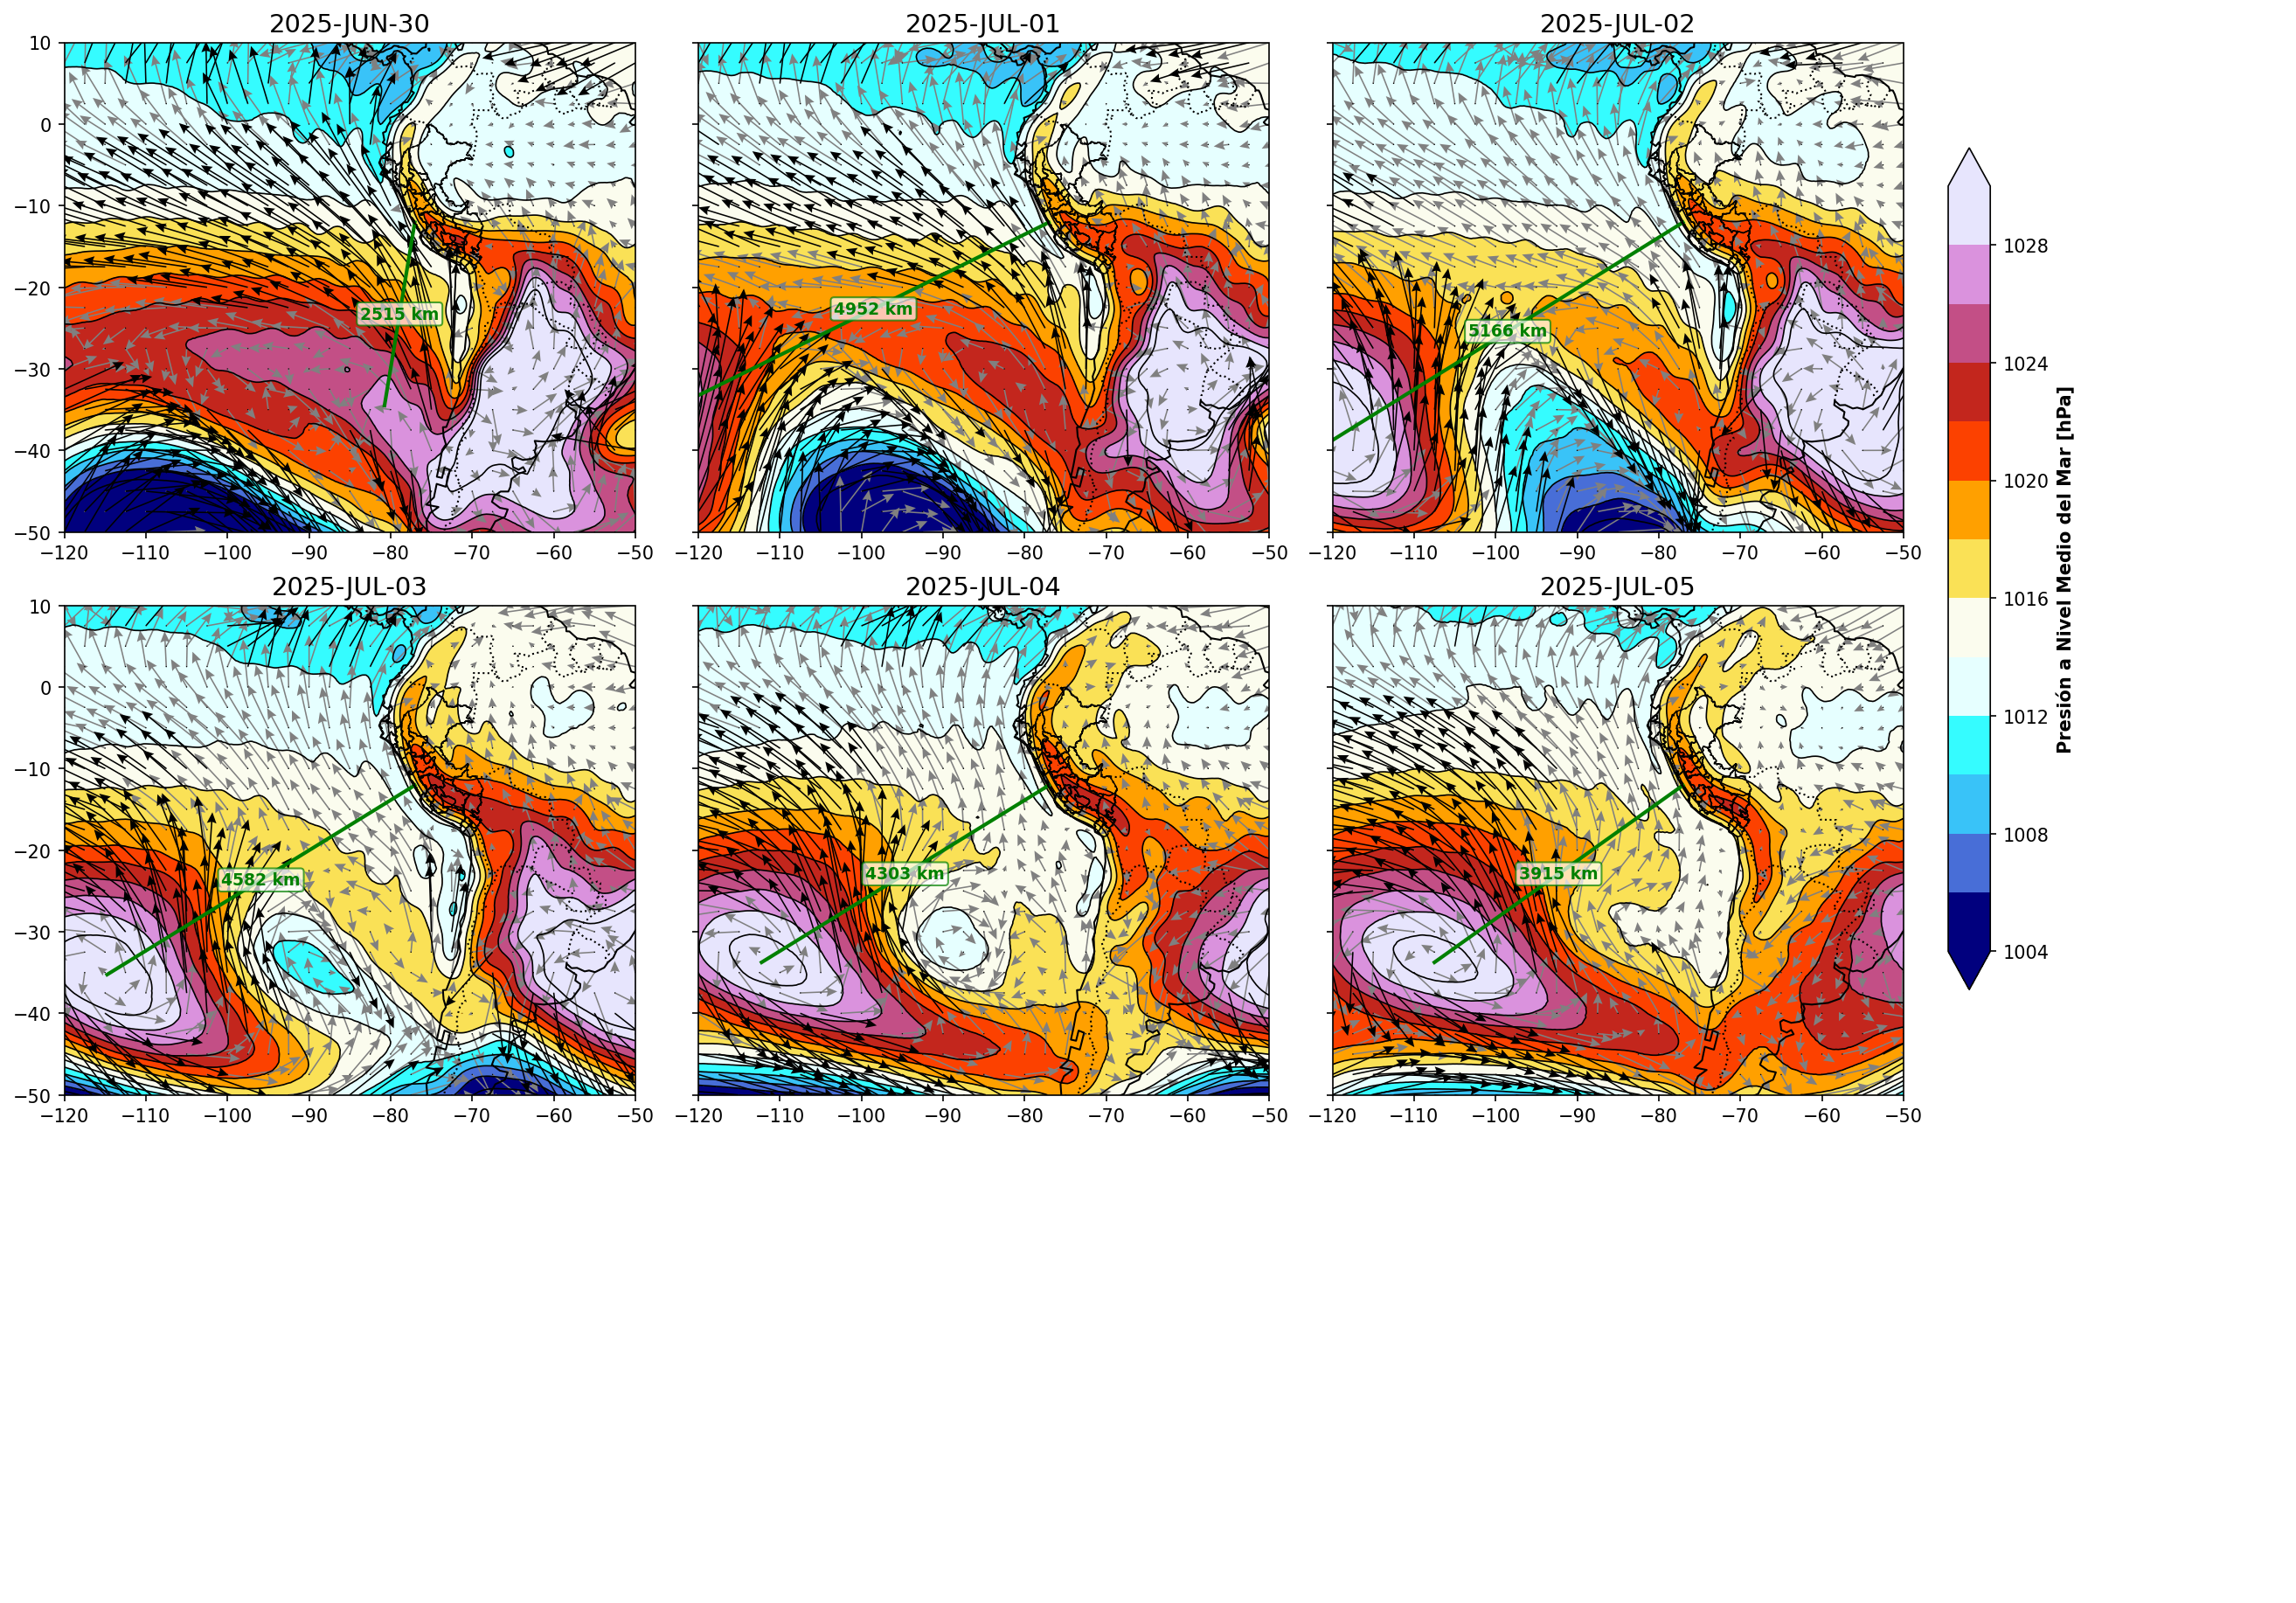

Imagen guardada como: ASP_presion_viento_DIA1-6_restringido_20250630_init20250630.png


In [ ]:
import xarray as xr
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import geopandas as gpd
import numpy as np
import pandas as pd
import tempfile
import requests
import os
from geopy.distance import geodesic

# === 0. FECHA DE INICIO MANUAL (o None para usar la más reciente disponible)
fecha_inicio_manual = "2025-06-30"  # Cambiar aquí la fecha deseada o usar None

# === 1. Descargar shapefile de Perú
shapefiles = {
    "departamentos.shp": "https://raw.githubusercontent.com/SMN-SENAMHI/Materiales/main/shape/DEPARTAMENTOS.shp",
    "departamentos.dbf": "https://raw.githubusercontent.com/SMN-SENAMHI/Materiales/main/shape/DEPARTAMENTOS.dbf",
    "departamentos.shx": "https://raw.githubusercontent.com/SMN-SENAMHI/Materiales/main/shape/DEPARTAMENTOS.shx",
}

tempdir = tempfile.mkdtemp()
for filename, url in shapefiles.items():
    response = requests.get(url)
    with open(os.path.join(tempdir, filename), "wb") as f:
        f.write(response.content)

gdf_peru = gpd.read_file(os.path.join(tempdir, "departamentos.shp"))

# === 2. Abrir dataset GEFS
ds = xr.open_zarr(
    "https://data.dynamical.org/noaa/gefs/forecast-35-day/latest.zarr?email=optional@email.com",
    decode_timedelta=True
)

latest_init = ds.init_time.max().values
init_time = np.datetime64(fecha_inicio_manual) if fecha_inicio_manual else latest_init
print("Usando init_time:", pd.to_datetime(init_time).strftime("%Y-%m-%d"))

# === 3. Subset de región y tiempo
ds_sub = ds.sel(init_time=init_time).sel(latitude=slice(10, -50), longitude=slice(-120, -50))
ds_members = ds_sub.sel(lead_time=slice("0h", "6d"))

pressure_all = ds_members["pressure_reduced_to_mean_sea_level"] / 100  # Pa a hPa
u10_all = ds_members["wind_u_10m"]
v10_all = ds_members["wind_v_10m"]

# === 4. Ajuste de tiempo
forecast_time = ds_members.init_time + ds_members.lead_time
pressure_all = pressure_all.assign_coords(forecast_time=forecast_time).swap_dims({"lead_time": "forecast_time"})
u10_all = u10_all.assign_coords(forecast_time=forecast_time).swap_dims({"lead_time": "forecast_time"})
v10_all = v10_all.assign_coords(forecast_time=forecast_time).swap_dims({"lead_time": "forecast_time"})

# === 5. Agrupar por día
pressure_daily_all = pressure_all.groupby("forecast_time.date").mean(dim="forecast_time")
u10_daily_all = u10_all.groupby("forecast_time.date").mean(dim="forecast_time")
v10_daily_all = v10_all.groupby("forecast_time.date").mean(dim="forecast_time")

# === 6. Promedio ensemble
pressure_prom = pressure_daily_all.mean(dim="ensemble_member")
u10_prom = u10_daily_all.mean(dim="ensemble_member")
v10_prom = v10_daily_all.mean(dim="ensemble_member")

# === 7. Configuración visual
extent = [-120, -50, -50, 10]
x_ticks = range(-120, -49, 10)
y_ticks = range(-50, 11, 10)

colors = ["#01007E", "#486ED7", "#39C3F8", "#35FCFF", "#E6FFFF",
          "#FBFCEE", "#F6F6DE", "#FAE156", "#FFA000", "#FC4100",
          "#C3261D", "#C34F86", "#DA92DD", "#E7E5FD"]
cmap_custom = mcolors.ListedColormap(colors)
contour_levels = np.arange(1004, 1032, 2)

# === 8. Graficar en figura 3x3
fig, axes = plt.subplots(3, 3, figsize=(22, 16), subplot_kw={'projection': ccrs.PlateCarree()}, dpi=150)
axes = axes.flatten()
fig.subplots_adjust(wspace=0.08, hspace=0.15)

for i in range(6):  # solo 6 días
    ax = axes[i]
    pres_avg = pressure_prom.isel(date=i)
    u10_avg = u10_prom.isel(date=i)
    v10_avg = v10_prom.isel(date=i)

    lon, lat = np.meshgrid(pres_avg.longitude.values, pres_avg.latitude.values)
    uwnd_values = u10_avg.values
    vwnd_values = v10_avg.values
    mslp_values = pres_avg.values

    wind_magnitude = np.sqrt(uwnd_values**2 + vwnd_values**2)
    mask_black = wind_magnitude > 7
    mask_gray = ~mask_black

    ax.set_extent(extent, crs=ccrs.PlateCarree())
    ax.set_xticks(x_ticks, crs=ccrs.PlateCarree())
    ax.set_yticks(y_ticks, crs=ccrs.PlateCarree())
    ax.tick_params(labelbottom=True, labelleft=(i % 3 == 0))
    ax.coastlines()
    ax.add_feature(cfeature.BORDERS, linestyle=":")
    ax.add_feature(cfeature.LAND, edgecolor='black', alpha=0.3)

    cmap_mslp = ax.contourf(lon, lat, mslp_values, levels=contour_levels, cmap=cmap_custom, extend='both')
    ax.contour(lon, lat, mslp_values, levels=contour_levels, colors='black', linewidths=0.8)

    skip = (slice(None, None, 10), slice(None, None, 10))
    ax.quiver(lon[skip], lat[skip],
              uwnd_values[skip] * mask_gray[skip], vwnd_values[skip] * mask_gray[skip],
              color='#808080', scale=1.0, scale_units='xy', headlength=8, headwidth=7, headaxislength=7)
    ax.quiver(lon[skip], lat[skip],
              uwnd_values[skip] * mask_black[skip], vwnd_values[skip] * mask_black[skip],
              color='black', scale=1.0, scale_units='xy', headlength=8, headwidth=7, headaxislength=7)

    gdf_peru.boundary.plot(ax=ax, edgecolor='black', linewidth=0.7, zorder=10)

    pres_sub = pres_avg.sel(latitude=slice(-10, -50), longitude=slice(-120, -80))
    lon_sub, lat_sub = np.meshgrid(pres_sub.longitude.values, pres_sub.latitude.values)
    idx_max = np.unravel_index(np.argmax(pres_sub.values, axis=None), pres_sub.shape)
    lat_max = lat_sub[idx_max]
    lon_max = lon_sub[idx_max]

    lat_lima, lon_lima = -12.05, -77.04
    ax.plot([lon_max, lon_lima], [lat_max, lat_lima], color='green', linewidth=2, transform=ccrs.PlateCarree())
    distancia_km = geodesic((lat_max, lon_max), (lat_lima, lon_lima)).kilometers
    lat_text = (lat_max + lat_lima) / 2
    lon_text = (lon_max + lon_lima) / 2
    ax.text(lon_text, lat_text, f"{distancia_km:.0f} km", fontsize=9, color='green',
            weight='bold', transform=ccrs.PlateCarree(), ha='center', va='center',
            bbox=dict(boxstyle="round,pad=0.2", fc="white", ec="green", alpha=0.7))

    # === TÍTULO: YYYY-MES-DD
    fecha_plot = pd.to_datetime(str(pressure_prom.date.values[i])).strftime("%Y-%b-%d").upper()
    ax.set_title(f"{fecha_plot}", fontsize=14)

# === Vaciar los subplots sobrantes
for i in range(6, 9):
    axes[i].axis('off')

# === Barra de color
cbar = fig.colorbar(cmap_mslp, ax=axes[:6], orientation="vertical", shrink=0.8, pad=0.02)
cbar.set_label("Presión a Nivel Medio del Mar [hPa]", fontsize=10, weight='bold')

# === Guardar imagen
start_forecast = pd.to_datetime(str(pressure_prom.date.values[0])).strftime("%Y%m%d")
output_file = f"ASP_presion_viento_DIA1-6_restringido_{start_forecast}_init{pd.to_datetime(init_time).strftime('%Y%m%d')}.png"
plt.savefig(output_file, bbox_inches='tight', pad_inches=0.1)
plt.show()

print(f"Imagen guardada como: {output_file}")
